In [2]:
# AIDI_1002_Reproducibility_Notebook
# Project: Stock Market Prediction using Daily News Headlines
# Goal: Reproduce original repo results (Random Forest, Naive Bayes, Logistic Regression) and log metrics and add a New model (MLP Classifier)

In [2]:
#Environment setup
!pip install --quiet numpy pandas scikit-learn matplotlib seaborn nltk joblib
!python -m nltk.downloader -q punkt stopwords wordnet

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour


In [4]:
#Importing and reproducibility settings
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [6]:
#Reproducibility seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [12]:
#importing dataset
from google.colab import files
uploaded = files.upload()

Saving Combined_News_DJIA.csv to Combined_News_DJIA (1).csv


In [14]:
DATA_PATH = "Combined_News_DJIA.csv"

In [16]:
#Loading the CSV
assert os.path.exists(DATA_PATH), f"Data file not found at {DATA_PATH}. Upload it to that path."
df = pd.read_csv(DATA_PATH)
df.head()


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [17]:
#Basic label distribution
print('\nLabel distribution:')
print(df['Label'].value_counts(normalize=True))


Label distribution:
Label
1    0.535445
0    0.464555
Name: proportion, dtype: float64


In [18]:
#Showing sample concatenation of Top1..Top25
headline_cols = [f'Top{i}' for i in range(1,26)]
print('\nExample headlines concatenated:')
print(' '.join(df.loc[0, headline_cols].astype(str).values))


Example headlines concatenated:
b"Georgia 'downs two Russian warplanes' as countries move to brink of war" b'BREAKING: Musharraf to be impeached.' b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)' b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire' b"Afghan children raped with 'impunity,' U.N. official says - this is sick, a three year old was raped and they do nothing" b'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.' b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO's side" b"The 'enemy combatent' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." b'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]' b'Did the U.S. Prep Georgia for War 

In [24]:
#Preprocessing helper functions
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text, remove_stopwords=True, lemmatize=True):
  # basic cleaning
    text = str(text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", ' ', text)
    tokens = text.split()
    if remove_stopwords:
     tokens = [t for t in tokens if t not in stop_words]
    if lemmatize:
     tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)



In [25]:
#Concatenating Top1..Top25 into a single column and clean

df['text'] = df[headline_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df['text_clean'] = df['text'].apply(lambda t: clean_text(t))
print(df[['Date','Label','text_clean']].head(2).T)

                                                            0  \
Date                                               2008-08-08   
Label                                                       0   
text_clean  b georgia down two russian warplane country mo...   

                                                            1  
Date                                               2008-08-11  
Label                                                       1  
text_clean  b wont america nato help u wont help u help ir...  


In [27]:
#Train/test split
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

X_train = df_train['text_clean'].values
y_train = df_train['Label'].values
X_test = df_test['text_clean'].values
y_test = df_test['Label'].values

print('Train size, Test size', len(X_train), len(X_test))

Train size, Test size 1591 398


In [28]:
#Vectorization
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print('Vectorized shape', X_train_vec.shape, X_test_vec.shape)

Vectorized shape (1591, 5000) (398, 5000)


In [30]:
#Baseline models (training and evaluating)

# Function to evaluate and return metrics
def evaluate_model(model, X_tr, y_tr, X_te, y_te, name='model'):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    print(f'== {name} ==')
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1:', f1)
    print('\nConfusion matrix:\n', confusion_matrix(y_te, y_pred))
    return {'name': name, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}


# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_metrics = evaluate_model(rf, X_train_vec, y_train, X_test_vec, y_test, name='RandomForest')


# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr_metrics = evaluate_model(lr, X_train_vec, y_train, X_test_vec, y_test, name='LogisticRegression')


# Naive Bayes
nb = MultinomialNB()
nb_metrics = evaluate_model(nb, X_train_vec, y_train, X_test_vec, y_test, name='MultinomialNB')

== RandomForest ==
Accuracy: 0.5226130653266332
Precision: 0.5215827338129496
Recall: 0.7178217821782178
F1: 0.6041666666666666

Confusion matrix:
 [[ 63 133]
 [ 57 145]]
== LogisticRegression ==
Accuracy: 0.43467336683417085
Precision: 0.4534412955465587
Recall: 0.5544554455445545
F1: 0.49888641425389757

Confusion matrix:
 [[ 61 135]
 [ 90 112]]
== MultinomialNB ==
Accuracy: 0.49748743718592964
Precision: 0.50390625
Recall: 0.6386138613861386
F1: 0.5633187772925764

Confusion matrix:
 [[ 69 127]
 [ 73 129]]


                 name       acc      prec       rec        f1
0        RandomForest  0.522613  0.521583  0.717822  0.604167
1  LogisticRegression  0.434673  0.453441  0.554455  0.498886
2       MultinomialNB  0.497487  0.503906  0.638614  0.563319


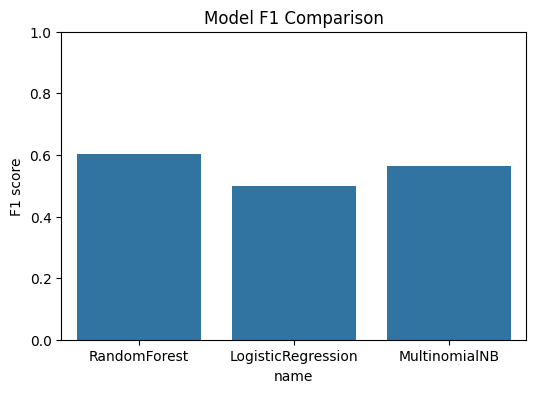

In [31]:
#Collecting results and visualizations
results = pd.DataFrame([rf_metrics, lr_metrics, nb_metrics])
print(results)

# Bar plot of F1 scores
plt.figure(figsize=(6,4))
sns.barplot(data=results, x='name', y='f1')
plt.title('Model F1 Comparison')
plt.ylabel('F1 score')
plt.ylim(0,1)
plt.show()

In [32]:
#Saving vectorizer and models
os.makedirs('models', exist_ok=True)
dump(vectorizer, 'models/count_vectorizer.joblib')
dump(rf, 'models/rf_baseline.joblib')
dump(lr, 'models/lr_baseline.joblib')
dump(nb, 'models/nb_baseline.joblib')
print('Saved models to models/')

Saved models to models/


In [ ]:
#OPTION 3: Adding a NEW MODEL (MLP Classifier) for testing the results

In [34]:
#Importing required libraries
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
#Defining the MLP classifier
# MLP pipeline
mlp = MLPClassifier(max_iter=500, random_state=42)

# Hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(100,50), (150,100), (200,100)],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh']
}

# Grid search
grid = GridSearchCV(mlp, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(X_train_vec, y_train)

print("Best parameters:", grid.best_params_)
best_mlp = grid.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (150, 100)}


=== MLP Classifier Results ===
Accuracy: 0.46984924623115576
Precision: 0.4828897338403042
Recall: 0.6287128712871287
F1 Score: 0.546236559139785


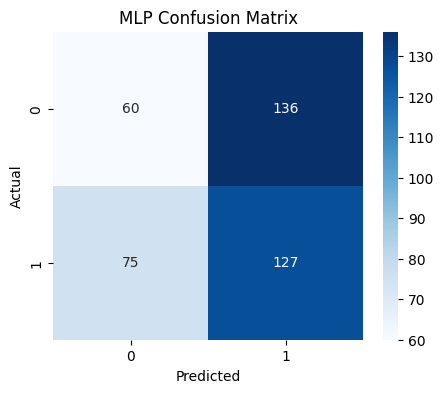

In [36]:
#Evaluating MLP
y_pred = best_mlp.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== MLP Classifier Results ===")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MLP Confusion Matrix")
plt.show()

                 name       acc      prec       rec        f1
0        RandomForest  0.522613  0.521583  0.717822  0.604167
1  LogisticRegression  0.434673  0.453441  0.554455  0.498886
2       MultinomialNB  0.497487  0.503906  0.638614  0.563319
3       MLPClassifier  0.469849  0.482890  0.628713  0.546237


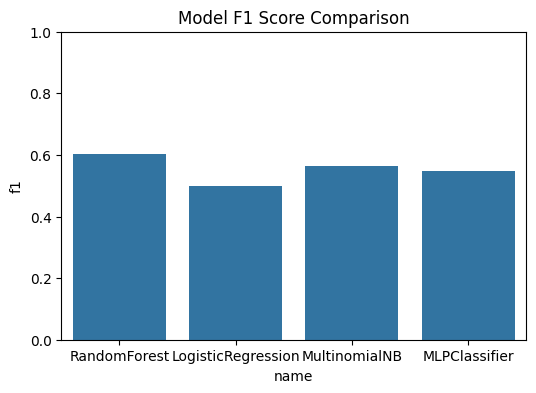

In [37]:
#Comapring MLP with the baseline
import pandas as pd

results = pd.DataFrame([
    {'name': 'RandomForest', 'acc': rf_metrics['acc'], 'prec': rf_metrics['prec'], 'rec': rf_metrics['rec'], 'f1': rf_metrics['f1']},
    {'name': 'LogisticRegression', 'acc': lr_metrics['acc'], 'prec': lr_metrics['prec'], 'rec': lr_metrics['rec'], 'f1': lr_metrics['f1']},
    {'name': 'MultinomialNB', 'acc': nb_metrics['acc'], 'prec': nb_metrics['prec'], 'rec': nb_metrics['rec'], 'f1': nb_metrics['f1']},
    {'name': 'MLPClassifier', 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}
])

print(results)

# Bar plot for F1 comparison
plt.figure(figsize=(6,4))
sns.barplot(data=results, x='name', y='f1')
plt.ylim(0,1)
plt.title('Model F1 Score Comparison')
plt.show()


In [38]:
#Saving MLP models
from joblib import dump
import os
os.makedirs('models', exist_ok=True)

dump(best_mlp, 'models/mlp_medium.joblib')
print("MLP model saved to models/mlp_medium.joblib")


MLP model saved to models/mlp_medium.joblib
